In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time as tm

In [3]:
def lttb(dataframe, threshold):
    """
    Downsamples a pandas DataFrame using Largest Triangle Three Buckets algorithm.

    Parameters:
    - dataframe: Input data as a pandas DataFrame with 'time' and 'signal' columns.
    - threshold: The number of points to reduce the data to.

    Returns:
    - Downsampled data as a pandas DataFrame with 'time' and 'signal' columns.
    """
    data_length = len(dataframe)
    if threshold >= data_length or threshold == 0:
        return dataframe  # No need to downsample
    
    # Convert DataFrame to list of lists for easier manipulation
    data = dataframe[['ts', 'values']].values.tolist()
    
    # Bucket size. Leave room for first and last data points.
    every = (data_length - 2) / (threshold - 2)
    
    a = 0  # Initially a is the first point in the triangle.
    max_area_point = []  # The downsampled data.
    max_area_point.append(data[a])  # Always add the first point.
    
    next_a = 0
    for i in range(0, threshold - 2):
        # Calculate range for this bucket.
        avg_range_start = int(np.floor((i + 1) * every) + 1)
        avg_range_end = int(np.floor((i + 2) * every) + 1)
        avg_range_end = min(avg_range_end, data_length)  # In case of a rounding error.
        
        # Calculate average time and signal values of the points in the next bucket.
        avg_time = np.mean([data[j][0] for j in range(avg_range_start, avg_range_end)])
        avg_signal = np.mean([data[j][1] for j in range(avg_range_start, avg_range_end)])
        
        # Get the range for this bucket.
        range_offs = int(np.floor((i + 0) * every) + 1)
        range_to = int(np.floor((i + 1) * every) + 1)
        
        # Point a is selected as the point that forms the largest triangle.
        max_area = -1
        for j in range(range_offs, range_to):
            # Calculate area of the triangle.
            area = abs((data[a][0] - avg_time) * (data[j][1] - data[a][1]) -
                       (data[a][0] - data[j][0]) * (avg_signal - data[a][1])) * 0.5
            if area > max_area:
                max_area = area
                next_a = j  # Next a is the point with the largest triangle.
        
        max_area_point.append(data[next_a])  # Add the next a point.
        a = next_a  # Set a to the new a.
    
    max_area_point.append(data[-1])  # Always add the last point.
    
    # Convert the list of downsampled points back to a DataFrame
    downsampled_df = pd.DataFrame(max_area_point, columns=['ts', 'values'])
    
    return downsampled_df

In [4]:
def find_last_and_sum(signals, points):   ########### O(m*p*logn)
    
    resampled_timestamps = points['ts'].values   # O(p)
    
    # Store the last available indices for each signal
    indices = []    # O(1)
    signal_values_list = []   # O(1)
    
    for signal in signals:   ###### O(m)
        signal_timestamps = signal['ts'].values   # O(m)
        signal_values = signal['values'].values   # O(m)
        
        # Find the last valid index for each resampled timestamp
        index = np.searchsorted(signal_timestamps, resampled_timestamps, side='right') - 1   ###### O(mp*logn)
        index[(resampled_timestamps < signal_timestamps[0]) | (resampled_timestamps > signal_timestamps[-1])] = -1   # O(m)

        # Store the indices and values
        indices.append(index)    # O(m)
        signal_values_list.append(signal_values)   # O(m)
    ###### O(m*p*logn)
    
    summed_values = []   # O(1)
    
    start_time = tm.time()   # O(1)

    for i, ts in enumerate(resampled_timestamps):   ###### O(p)
        summed_value = 0   # Start sum at zero   # O(p)
        
        for j in range(len(signals)):   ###### O(m)
            idx = indices[j][i]  # Retrieve the index for the current signal   # O(mp)
            
            # Set value to zero if index is out of range
            if idx < 0:  
                value = 0   # O(mp)
            else:
                value = signal_values_list[j][idx]   # O(mp)
            
            summed_value += value   # Sum values   # O(mp)
        
        # Handle extra point values from 'points' DataFrame
        point_value = points['values'].values[i]      # O(1)
        summed_value += point_value   # O(1)
        
        summed_values.append(summed_value)   # O(1)
    ###### O(m*p)
    
    # End timing
    end_time = tm.time()   # O(1)
    summation_time = end_time - start_time   # O(1) 
    
    return pd.DataFrame({
        'ts': resampled_timestamps,   
        'summed_value': summed_values  
    }) 

def process_multiple_signals(signals, threshold):
    total_start_time = tm.time()  # O(1)

    # Apply LTTB downsampling to all signals individually
    resampled_signals = [lttb(signal, threshold) for signal in signals]   ###### O(m*n)

    # Initialize merged DataFrame as None
    merged_df = None     # O(1)

    for i, resampled_signal in enumerate(resampled_signals):   # O(m)
        # Find the most recent values from all original signals and sum them
        summed_df = find_last_and_sum([s for j, s in enumerate(signals) if j != i], resampled_signal)  ###### O(m^2*p*logn)

        if merged_df is None:
            merged_df = summed_df  # First iteration, initialize merged_df   # O(1)
        else:
            # Full outer join with previous results
            merged_df = merged_df.merge(summed_df, on='ts', how='outer', suffixes=('', '_drop'))   # O(1)

    total_end_time = tm.time()
    total_processing_time = total_end_time - total_start_time
    print(f"Total processing time: {total_processing_time:.4f} seconds")
    
    return merged_df

# O(m*n) + O(m^2*p*logn) = O(m*n + m^2*p*logn)
# since p << n, m << n,  --> O(m*n) 

In [5]:
import matplotlib.pyplot as plt

def plot_multiple_signals(signals, threshold):
    """
    Plot multiple signals, their downsampled versions, and computed summed values.
    
    :param signals: List of signal DataFrames, each containing 'ts' and 'values'.
    :param threshold: LTTB downsampling threshold.
    """
    plt.figure(figsize=(15, 9))
    
    # Generate enough colors for plotting
    colors = plt.cm.tab10(np.linspace(0, 1, len(signals)))

    # Plot original signals
    for i, signal in enumerate(signals):
        plt.plot(signal['ts'], signal['values'], color=colors[i], label=f'Signal {i+1}')
    
    # Apply LTTB downsampling to all signals
    downsampled_signals = [lttb(signal, threshold) for signal in signals]
    
    # Plot downsampled signals
    for i, downsampled in enumerate(downsampled_signals):
        plt.plot(downsampled['ts'], downsampled['values'], 'o', color=colors[i], label=f'Downsampled Signal {i+1}')
    
    # Compute summed values
    merged_df = process_multiple_signals(signals, threshold)

    # Dynamically find all summed value columns
    summed_columns = [col for col in merged_df.columns if 'summed_value' in col]

    merged_df['summed_value_total'] = merged_df[summed_columns].sum(axis=1, min_count=1)
    plt.plot(merged_df['ts'], merged_df['summed_value_total'], c='red', label='LTTB_SUM')

    # Create a common time grid
    all_timestamps = np.sort(np.unique(np.concatenate([signal['ts'].values for signal in signals])))

    # Interpolate all signals onto the common time grid
    interpolated_signals = [np.interp(all_timestamps, signal['ts'].values, signal['values'].values) for signal in signals]

    # Compute interpolated sum
    sum_interpolated = np.sum(interpolated_signals, axis=0)

    # Create a DataFrame for the summed interpolated values
    interpolated_sum_df = pd.DataFrame({'ts': all_timestamps, 'values': sum_interpolated})

    # Plot Linear Interpolation Sum
    plt.plot(interpolated_sum_df['ts'], interpolated_sum_df['values'], c='black', linestyle='--', label='Linear Interpolation SUM')

    ### **Plot Settings**
    plt.title('LTTB SUM vs Linear Interpolation Sum')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()


Total processing time: 0.0072 seconds


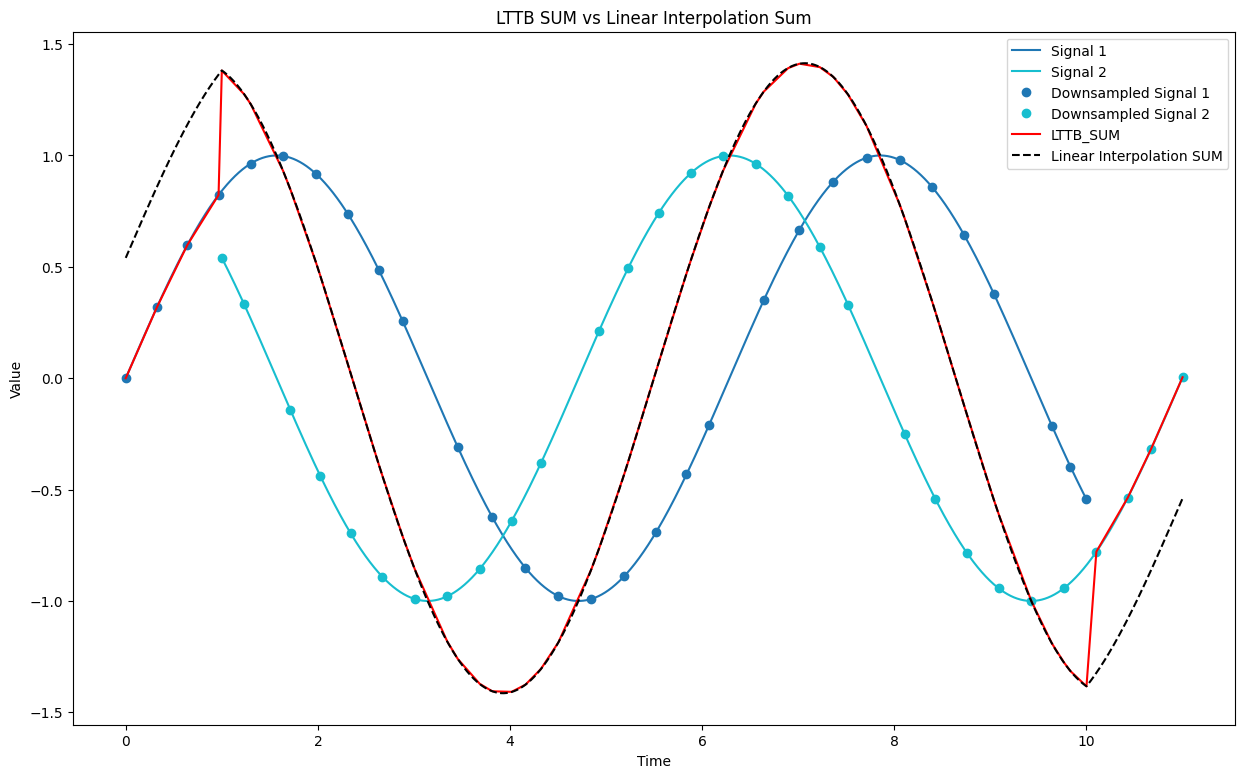

In [6]:
from scipy import signal

# Generate time series data
np.random.seed(42)  # for reproducibility
number = 10000
time1 = np.linspace(0, 10, number)
time2 = np.linspace(1, 11, number)
signal_1 = np.sin(time1)
signal_2 = np.cos(time2)

# Update the DataFrame
df = pd.DataFrame({'Time1': time1, 'Time2': time2, 'Signal 1': signal_1, 'Signal 2': signal_2})

df_signal_1 = df[['Time1','Signal 1']]
df_signal_1 = df_signal_1.rename(columns={"Time1": "ts", "Signal 1": "values"})
df_signal_2 = df[['Time2','Signal 2']]
df_signal_2 = df_signal_2.rename(columns={"Time2": "ts", "Signal 2": "values"})

threshold = 30

signals = [df_signal_1, df_signal_2]
plot_multiple_signals(signals, threshold)